# Clients & Methods

> Classes that instantiate GCP services' Python API clients.

In [ ]:
#| default_exp clients

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#|hide
#| eval: false
! [ -e /content ] && pip install -Uqq gcp_python_client_functions

In [ ]:
#|hide
#| export
from fastcore.test import *
from fastcore.basics import *

## Authentication

Before you instantiate a class, remember authenticating using any of the following methods.

- Using the [Google Cloud SDK](http://cloud.google.com/sdk)(installation needed):

In [ ]:
#!gcloud auth login --update-adc

- [Downloading a service account JSON keyfile](https://cloud.google.com/iam/docs/keys-create-delete#creating) and point to it using an environment variable:

In [ ]:
#!export GOOGLE_APPLICATION_CREDENTIALS="/path/to/keyfile.json"

In [ ]:
#|export
from google.cloud import bigquery

In [ ]:
#| export
class BigQuery:
    """
    BigQuery client generation and additional methods
    """
    def __init__(
        self, 
        project_id: str, # GCP project ID
    ): 
        self.project_id = project_id
        self.client = bigquery.Client(project_id)
        
    def __repr__(self): return f'BigQuery Object ({self.project_id})'

**Example 1**: using the BigQuery client to perform a query job.

In [ ]:
# 1. Instantiate object:
PROJECT_ID = 'dz-learning-d'
bq_obj = BigQuery(PROJECT_ID)

# 2. Execute job:
DATASET = 'new_dataset'
TABLE = 'new_view'
QUERY = """
        CREATE SCHEMA IF NOT EXISTS {dataset}
        OPTIONS(
        location="us",
        default_table_expiration_days=3.75,
        labels=[("purpose","learning"),("project","package")]
        );

        CREATE OR REPLACE VIEW `{project_id}.{dataset}.{table}`
        OPTIONS(
        expiration_timestamp=TIMESTAMP_ADD(
                CURRENT_TIMESTAMP(), INTERVAL 48 HOUR),
        friendly_name="new_view",
        description="a view that expires in 2 days",
        labels=[("purpose", "learning")]
        )
        AS SELECT name, state, year, number
        FROM `bigquery-public-data.usa_names.usa_1910_current`
        WHERE state LIKE 'W%'
        """.format(project_id = PROJECT_ID, dataset = DATASET, table = TABLE)

job = bq_obj.client.query(QUERY)  # API request.
job.result()  # Waits for the query to finish.
print(job)

QueryJob<project=dz-learning-d, location=US, id=9a4cd539-d063-429d-bff8-1a7b64a6620c>


Which results in a brand new dataset and view on our project: 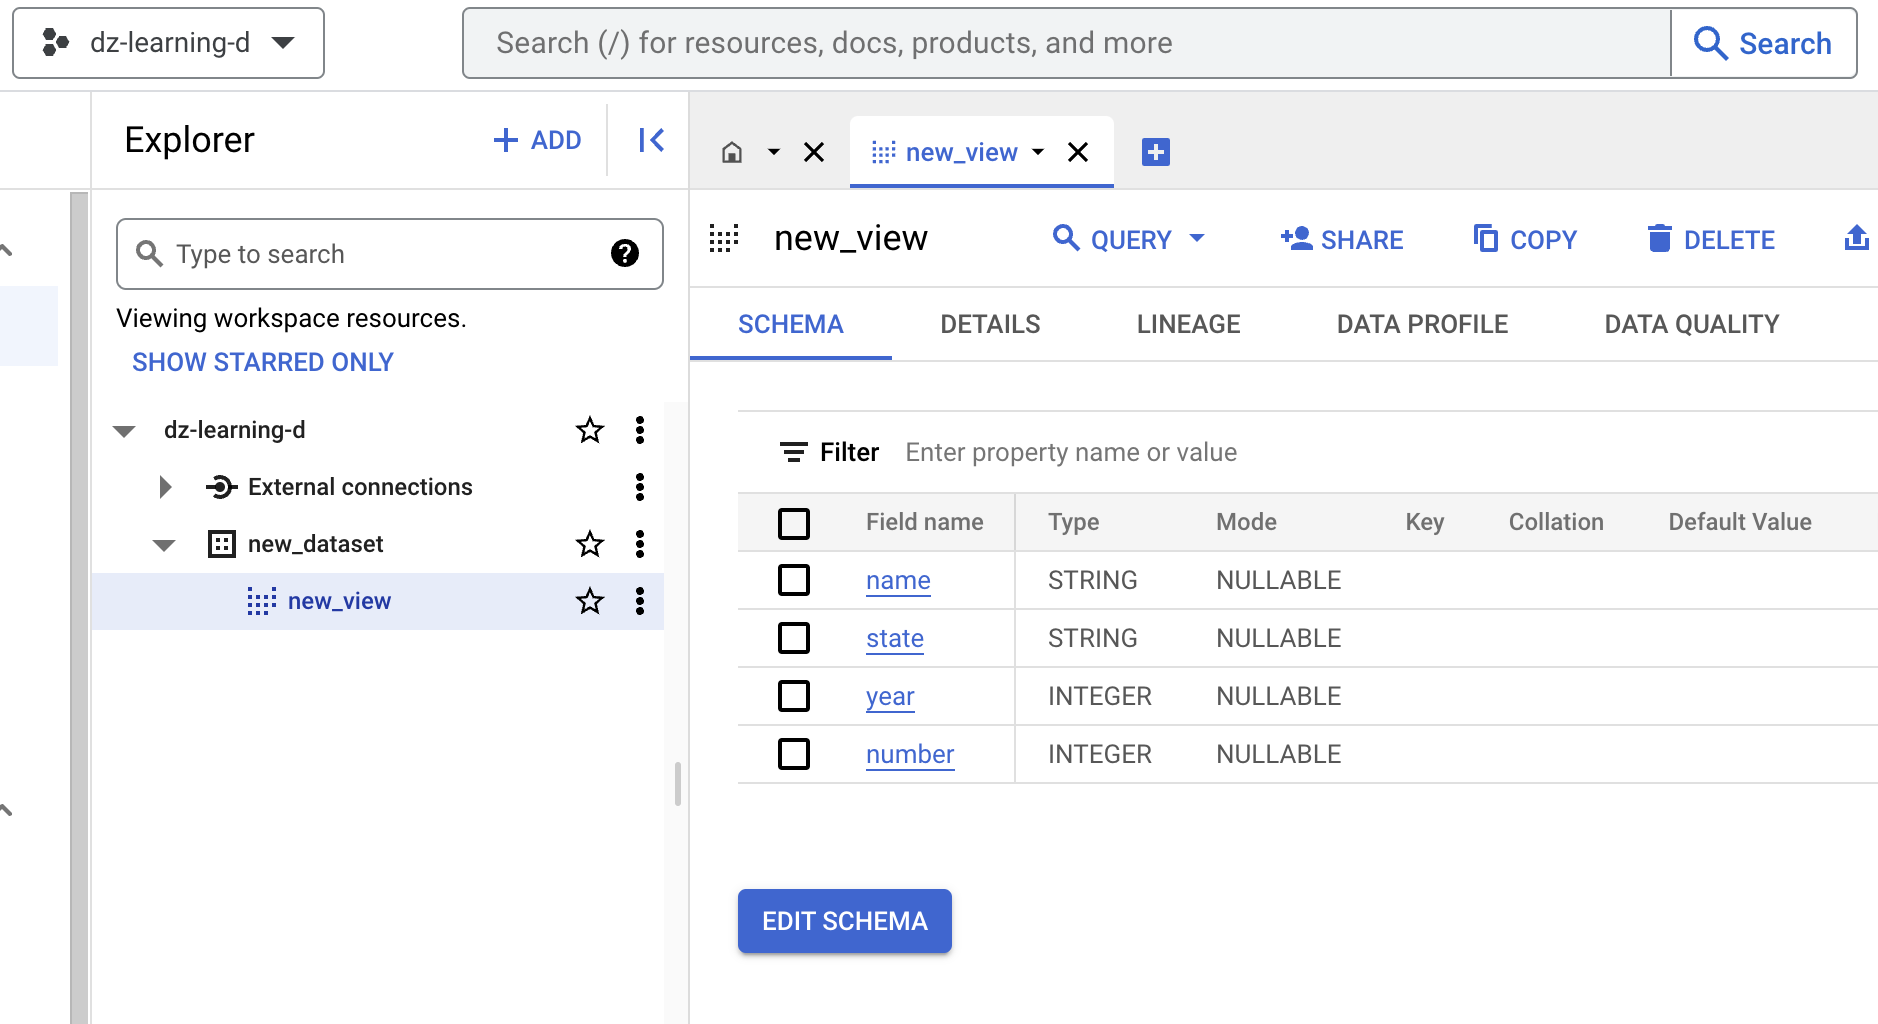

**Example 2**: using the BigQuery client to perform a SQL query and save the results in a dataframe.

In [ ]:
# 1. Instantiate object:
PROJECT_ID = 'dz-learning-d'
bq_obj = BigQuery(PROJECT_ID)

# 2. Execute SQL and save results in dataframe:
QUERY = """
        SELECT name FROM `bigquery-public-data.usa_names.usa_1910_2013`
        WHERE state = "TX"
        LIMIT 100
        """
df = bq_obj.client.query(QUERY).to_dataframe()
df

,name
0,Mary
1,Roberta
2,Marguerite
3,Katie
4,Eunice
...,...
95,Rita
96,Elida
97,Billie
98,Ida


In [ ]:
#| hide
# Test [BigQuery]:
import pandas as pd

PROJECT_ID = 'dz-learning-d'
bq_obj = BigQuery(PROJECT_ID)

QUERY = """
        SELECT name FROM `bigquery-public-data.usa_names.usa_1910_2013`
        WHERE state = "TX"
        LIMIT 100
        """
df = bq_obj.client.query(QUERY).to_dataframe()
df_test = pd.read_pickle('gs://dz-d-stg-us-testartifacts/gcp-python-client-funtions/00_bigquery/00_bigquery_query_to_df.pkl')
assert df_test.equals(df)

In [ ]:
#|export
from google.cloud import storage
import os

In [ ]:
#|exporti
def extract_bucket_and_path(
    gcs_uri: str, # GCS URI. Ex: gs://bucket_name/[folder_name/]file_name
):
    """
    Auxiliary function to extract bucket and relative path from URI
    """
    if gcs_uri.startswith('gs://'):
        gcs_uri = gcs_uri.replace('gs://', '')
    if gcs_uri == '':
        raise ValueError(f'The gcs_uri provided is empty. "{gcs_uri}"')

    split = gcs_uri.split("/", 1)
    bucket = split.pop(0)
    path = split[0] if split and split[0] else ""

    return bucket, path

In [ ]:
# Test [extract_bucket_and_path]:
t_bucket = 'bucket_name'
t_path = 'folder_name_1/folder_name_2'
f_bucket, f_path = extract_bucket_and_path('gs://bucket_name/folder_name_1/folder_name_2')

test_eq(t_bucket, f_bucket)
test_eq(t_path, f_path)

In [ ]:
#| export
class Storage:
    """
    Cloud Storage client generation and additional methods
    """
    def __init__(
        self, 
        project_id: str, # GCP project ID
    ): 
        self.project_id = project_id
        self.client = storage.Client(project_id)
        
    def __repr__(self): return f'Cloud Storage Object ({self.project_id})'

In [ ]:
#| export
@patch
def download_files(
    self: Storage,
    gcs_uri: str, # GCS URI. Ex: gs://bucket_name/[folder_name/] 
    local_dir: str = "", # Local directory to download the file
    verbose: bool = True, # Boolean variable to print paths of files downloaded 
):
    """
    Download the files from a GCS location to a local directory
    """
    bucket_name, folder_path = extract_bucket_and_path(gcs_uri.rstrip('/'))

    # Get the bucket and list all blobs (files and objects) in the specified folder
    bucket = self.client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=folder_path)
    blob_list = list(blobs)

    files_downloaded = 0
    # Iterate through the blobs and download files
    for blob in blob_list:
        # Exclude folders
        if not blob.name.endswith('/'): 
            # Create the local path for the downloaded file
            new_path = os.path.join(local_dir, blob.name[len(folder_path) :].lstrip('/'))
            local_path = os.path.join(os.getcwd(), new_path)

            # Create directories if they don't exist
            os.makedirs(os.path.dirname(local_path), exist_ok=True)

            # Download the file from GCS to the local path
            blob.download_to_filename(local_path)

            if verbose:
                print(f'Downloaded {blob.name} to {new_path}')

            files_downloaded += 1
    return f'No. files downloaded: {files_downloaded}'

In [ ]:
# 1. Instantiate object:
PROJECT_ID = 'dz-learning-d'
stg_obj = Storage(PROJECT_ID)

# 2. Download files from GCS location to local:
GCS_URI = 'gs://dz-d-stg-us-testartifacts/gcp-python-client-funtions/01_storage/01_download_files_folder/'
LOCAL_DIR = 'test_sandbox/01_storage'

res = stg_obj.download_files(GCS_URI, LOCAL_DIR, False)
print(res)

# Test [download_files]:
test_eq(res, 'No. files downloaded: 4')

No. files downloaded: 4


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

Portions of this page are modifications based on work created and [shared by Google](https://developers.google.com/readme/policies) and used according to terms described in the [_Creative Commons 4.0 Attribution License_](https://creativecommons.org/licenses/by/4.0/).